In [1]:
# ==========================================================
# 🧩 Step 1: Install Required Libraries
# ==========================================================
#!pip install optuna lightgbm --quiet

# ==========================================================
# 🧩 Step 2: Import Libraries
# ==========================================================
import pandas as pd
import numpy as np
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from lightgbm import early_stopping

# ==========================================================
# 🧩 Step 3: Load Dataset (uploaded in Colab)
# ==========================================================
file_path = "C:/Users/boraw/Desktop/NASA1/k2pandc_2025.10.04_02.08.07 (1).csv"
print(f"📂 Loading dataset: {file_path}")

df = pd.read_csv(file_path, comment="#")
print("✅ Loaded successfully!")
print("Shape:", df.shape)
print("Columns (first 20):", df.columns[:20].tolist())

# ==========================================================
# 🧩 Step 4: Target Column Setup
# ==========================================================
# Use 'disposition' (since this is your dataset 2)
target_col = "disposition"

if target_col not in df.columns:
    raise ValueError(f"❌ Target column '{target_col}' not found in {file_path}")

print(f"🎯 Using target column: {target_col}")

# ==========================================================
# 🧩 Step 5: Prepare Data
# ==========================================================
# Select only numeric columns
X = df.select_dtypes(include=np.number)
y = df[target_col]

# Fill missing numeric values
X = X.fillna(0)

# Remove rows with missing targets
y = y.dropna()
X = X.loc[y.index]

# Encode target labels if they are strings
if y.dtype == "object":
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y = le.fit_transform(y)
    print("🔤 Encoded target labels:", list(le.classes_))

# Split data into train/test
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("✅ Data prepared for training!")
print("Training shape:", X_train.shape, "Validation shape:", X_val.shape)

# ==========================================================
# 🧩 Step 6: Define Optuna Objective Function
# ==========================================================
def objective(trial):
    params = {
        "objective": "multiclass",
        "num_class": len(np.unique(y)),
        "n_estimators": 500,
        "random_state": 42,
        "n_jobs": -1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 256),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 20, 300),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-4, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-4, 10.0, log=True),
    }

    model = lgb.LGBMClassifier(**params)

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric="multi_logloss",
        callbacks=[early_stopping(50, verbose=False)],
    )

    preds = model.predict(X_val)
    acc = accuracy_score(y_val, preds)
    return acc

# ==========================================================
# 🧩 Step 7: Run Optuna Optimization
# ==========================================================
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("\n" + "="*60)
print("🚀 OPTUNA OPTIMIZATION COMPLETE 🚀")
print("="*60)
print(f"✅ Best Accuracy: {study.best_value:.4f}")
print("📈 Best Hyperparameters:")
for key, value in study.best_params.items():
    print(f"  - {key}: {value}")

# ==========================================================
# 🧩 Step 8: Train Final Model with Best Params
# ==========================================================
best_params = study.best_params
best_params.update({
    "objective": "multiclass",
    "num_class": len(np.unique(y)),
    "n_estimators": 500,
    "random_state": 42,
})

final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="multi_logloss",
    callbacks=[early_stopping(50, verbose=False)],
)

# ==========================================================
# 🧩 Step 9: Evaluate Model
# ==========================================================
y_pred = final_model.predict(X_val)

print("\n🎯 Final Model Evaluation")
print("="*40)
print("✅ Accuracy:", accuracy_score(y_val, y_pred))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_pred))
print("\n🧩 Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))


C:\Users\boraw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-10-05 14:03:56,195] A new study created in memory with name: no-name-7f302e59-b770-4a4b-a148-cd73e2170552


📂 Loading dataset: C:/Users/boraw/Desktop/NASA1/k2pandc_2025.10.04_02.08.07 (1).csv
✅ Loaded successfully!
Shape: (4004, 94)
Columns (first 20): ['pl_name', 'hostname', 'default_flag', 'disposition', 'disp_refname', 'sy_snum', 'sy_pnum', 'discoverymethod', 'disc_year', 'disc_facility', 'soltype', 'pl_controv_flag', 'pl_refname', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbperlim', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2']
🎯 Using target column: disposition
🔤 Encoded target labels: ['CANDIDATE', 'CONFIRMED', 'FALSE POSITIVE', 'REFUTED']
✅ Data prepared for training!
Training shape: (3203, 76) Validation shape: (801, 76)
[LightGBM] [Warning] feature_fraction is set=0.9436082950651847, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9436082950651847
[LightGBM] [Warning] lambda_l1 is set=0.22627762523723519, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22627762523723519
[LightGBM] [Warning] lambda_l2 is set=3.2492852069369085, reg_lamb

[I 2025-10-05 14:03:58,353] Trial 0 finished with value: 0.9775280898876404 and parameters: {'learning_rate': 0.046095773254004054, 'num_leaves': 105, 'max_depth': 3, 'min_child_samples': 106, 'feature_fraction': 0.9436082950651847, 'bagging_fraction': 0.5035907403242932, 'bagging_freq': 4, 'lambda_l1': 0.22627762523723519, 'lambda_l2': 3.2492852069369085}. Best is trial 0 with value: 0.9775280898876404.


[LightGBM] [Warning] feature_fraction is set=0.9436082950651847, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9436082950651847
[LightGBM] [Warning] lambda_l1 is set=0.22627762523723519, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22627762523723519
[LightGBM] [Warning] lambda_l2 is set=3.2492852069369085, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2492852069369085
[LightGBM] [Warning] bagging_fraction is set=0.5035907403242932, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5035907403242932
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9730745890246655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9730745890246655
[LightGBM] [Warning] lambda_l1 is set=0.0008879125953546064, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008879125953546064
[LightGBM] [Warning] lambda_l

[I 2025-10-05 14:04:03,691] Trial 1 finished with value: 0.9762796504369539 and parameters: {'learning_rate': 0.009512438083515542, 'num_leaves': 182, 'max_depth': 8, 'min_child_samples': 148, 'feature_fraction': 0.9730745890246655, 'bagging_fraction': 0.8121948386579829, 'bagging_freq': 7, 'lambda_l1': 0.0008879125953546064, 'lambda_l2': 0.0014471616614715182}. Best is trial 0 with value: 0.9775280898876404.


[LightGBM] [Warning] feature_fraction is set=0.9730745890246655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9730745890246655
[LightGBM] [Warning] lambda_l1 is set=0.0008879125953546064, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008879125953546064
[LightGBM] [Warning] lambda_l2 is set=0.0014471616614715182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0014471616614715182
[LightGBM] [Warning] bagging_fraction is set=0.8121948386579829, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8121948386579829
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.9590636123383433, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9590636123383433
[LightGBM] [Warning] lambda_l1 is set=3.3745598213624484, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3745598213624484
[LightGBM] [Warning] lamb

[I 2025-10-05 14:04:05,791] Trial 2 finished with value: 0.9288389513108615 and parameters: {'learning_rate': 0.0022884489221566134, 'num_leaves': 199, 'max_depth': 12, 'min_child_samples': 287, 'feature_fraction': 0.9590636123383433, 'bagging_fraction': 0.8745866185926443, 'bagging_freq': 4, 'lambda_l1': 3.3745598213624484, 'lambda_l2': 0.04995774235216787}. Best is trial 0 with value: 0.9775280898876404.


[LightGBM] [Warning] feature_fraction is set=0.9590636123383433, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9590636123383433
[LightGBM] [Warning] lambda_l1 is set=3.3745598213624484, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3745598213624484
[LightGBM] [Warning] lambda_l2 is set=0.04995774235216787, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04995774235216787
[LightGBM] [Warning] bagging_fraction is set=0.8745866185926443, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8745866185926443
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6605779425641112, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6605779425641112
[LightGBM] [Warning] lambda_l1 is set=0.2788591458178063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2788591458178063
[LightGBM] [Warning] lambda_l2 is s

[I 2025-10-05 14:04:08,605] Trial 3 finished with value: 0.978776529338327 and parameters: {'learning_rate': 0.059264478551962874, 'num_leaves': 212, 'max_depth': 9, 'min_child_samples': 84, 'feature_fraction': 0.6605779425641112, 'bagging_fraction': 0.6941581120193112, 'bagging_freq': 7, 'lambda_l1': 0.2788591458178063, 'lambda_l2': 0.04610995950277461}. Best is trial 3 with value: 0.978776529338327.


[LightGBM] [Warning] feature_fraction is set=0.6605779425641112, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6605779425641112
[LightGBM] [Warning] lambda_l1 is set=0.2788591458178063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2788591458178063
[LightGBM] [Warning] lambda_l2 is set=0.04610995950277461, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04610995950277461
[LightGBM] [Warning] bagging_fraction is set=0.6941581120193112, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6941581120193112
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.9772053716339442, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9772053716339442
[LightGBM] [Warning] lambda_l1 is set=0.0018484458765421086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0018484458765421086
[LightGBM] [Warning] lambda_l

[I 2025-10-05 14:04:17,506] Trial 4 finished with value: 0.9812734082397003 and parameters: {'learning_rate': 0.014732263489944478, 'num_leaves': 111, 'max_depth': 9, 'min_child_samples': 43, 'feature_fraction': 0.9772053716339442, 'bagging_fraction': 0.8450499906432815, 'bagging_freq': 5, 'lambda_l1': 0.0018484458765421086, 'lambda_l2': 0.5525574277743127}. Best is trial 4 with value: 0.9812734082397003.


[LightGBM] [Warning] feature_fraction is set=0.9772053716339442, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9772053716339442
[LightGBM] [Warning] lambda_l1 is set=0.0018484458765421086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0018484458765421086
[LightGBM] [Warning] lambda_l2 is set=0.5525574277743127, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5525574277743127
[LightGBM] [Warning] bagging_fraction is set=0.8450499906432815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8450499906432815
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8598000489285738, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8598000489285738
[LightGBM] [Warning] lambda_l1 is set=0.9013535792293027, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9013535792293027
[LightGBM] [Warning] lambda_l2 

[I 2025-10-05 14:04:19,363] Trial 5 finished with value: 0.982521847690387 and parameters: {'learning_rate': 0.1636756455912193, 'num_leaves': 106, 'max_depth': 5, 'min_child_samples': 159, 'feature_fraction': 0.8598000489285738, 'bagging_fraction': 0.7983269929755135, 'bagging_freq': 2, 'lambda_l1': 0.9013535792293027, 'lambda_l2': 1.9887974555565218}. Best is trial 5 with value: 0.982521847690387.


[LightGBM] [Warning] feature_fraction is set=0.8598000489285738, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8598000489285738
[LightGBM] [Warning] lambda_l1 is set=0.9013535792293027, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9013535792293027
[LightGBM] [Warning] lambda_l2 is set=1.9887974555565218, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9887974555565218
[LightGBM] [Warning] bagging_fraction is set=0.7983269929755135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7983269929755135
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9437741281930876, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9437741281930876
[LightGBM] [Warning] lambda_l1 is set=0.000463290428398797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000463290428398797
[LightGBM] [Warning] lambda_l2 is

[I 2025-10-05 14:04:21,755] Trial 6 finished with value: 0.9538077403245943 and parameters: {'learning_rate': 0.0041892926234223145, 'num_leaves': 247, 'max_depth': 10, 'min_child_samples': 157, 'feature_fraction': 0.9437741281930876, 'bagging_fraction': 0.5961427972503197, 'bagging_freq': 6, 'lambda_l1': 0.000463290428398797, 'lambda_l2': 4.696636411292053}. Best is trial 5 with value: 0.982521847690387.


[LightGBM] [Warning] feature_fraction is set=0.9437741281930876, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9437741281930876
[LightGBM] [Warning] lambda_l1 is set=0.000463290428398797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000463290428398797
[LightGBM] [Warning] lambda_l2 is set=4.696636411292053, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.696636411292053
[LightGBM] [Warning] bagging_fraction is set=0.5961427972503197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5961427972503197
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5822017149322956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5822017149322956
[LightGBM] [Warning] lambda_l1 is set=0.0001421207795507334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001421207795507334
[LightGBM] [Warning] lambda_l

[I 2025-10-05 14:04:24,691] Trial 7 finished with value: 0.9413233458177278 and parameters: {'learning_rate': 0.0032210554417966466, 'num_leaves': 167, 'max_depth': 11, 'min_child_samples': 230, 'feature_fraction': 0.5822017149322956, 'bagging_fraction': 0.8204250455165839, 'bagging_freq': 6, 'lambda_l1': 0.0001421207795507334, 'lambda_l2': 2.321856866008122}. Best is trial 5 with value: 0.982521847690387.


[LightGBM] [Warning] feature_fraction is set=0.5822017149322956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5822017149322956
[LightGBM] [Warning] lambda_l1 is set=0.0001421207795507334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001421207795507334
[LightGBM] [Warning] lambda_l2 is set=2.321856866008122, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.321856866008122
[LightGBM] [Warning] bagging_fraction is set=0.8204250455165839, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8204250455165839
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8962131260795154, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8962131260795154
[LightGBM] [Warning] lambda_l1 is set=0.00012233643016497974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012233643016497974
[LightGBM] [Warning] lamb

[I 2025-10-05 14:04:28,485] Trial 8 finished with value: 0.9775280898876404 and parameters: {'learning_rate': 0.04560866531153739, 'num_leaves': 231, 'max_depth': 8, 'min_child_samples': 200, 'feature_fraction': 0.8962131260795154, 'bagging_fraction': 0.8300934330525356, 'bagging_freq': 3, 'lambda_l1': 0.00012233643016497974, 'lambda_l2': 0.03493621839168413}. Best is trial 5 with value: 0.982521847690387.


[LightGBM] [Warning] feature_fraction is set=0.8962131260795154, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8962131260795154
[LightGBM] [Warning] lambda_l1 is set=0.00012233643016497974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012233643016497974
[LightGBM] [Warning] lambda_l2 is set=0.03493621839168413, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03493621839168413
[LightGBM] [Warning] bagging_fraction is set=0.8300934330525356, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8300934330525356
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9129514431404412, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9129514431404412
[LightGBM] [Warning] lambda_l1 is set=6.824098246816687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.824098246816687
[LightGBM] [Warning] lambda_l

[I 2025-10-05 14:04:30,759] Trial 9 finished with value: 0.9700374531835206 and parameters: {'learning_rate': 0.11380998706892985, 'num_leaves': 75, 'max_depth': 11, 'min_child_samples': 180, 'feature_fraction': 0.9129514431404412, 'bagging_fraction': 0.5896652431039809, 'bagging_freq': 2, 'lambda_l1': 6.824098246816687, 'lambda_l2': 0.04124430346959772}. Best is trial 5 with value: 0.982521847690387.


[LightGBM] [Warning] feature_fraction is set=0.8013741254711343, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8013741254711343
[LightGBM] [Warning] lambda_l1 is set=0.019197583508474118, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.019197583508474118
[LightGBM] [Warning] lambda_l2 is set=0.00011637398343244002, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011637398343244002
[LightGBM] [Warning] bagging_fraction is set=0.9712746256393072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9712746256393072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8013741254711343, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8013741254711343
[LightGBM] [Warning] lambda_l1 is set=0.019197583508474118, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.019197583508474118
[LightGBM] [Warning] 

[I 2025-10-05 14:04:31,806] Trial 10 finished with value: 0.9762796504369539 and parameters: {'learning_rate': 0.2153819711953233, 'num_leaves': 20, 'max_depth': 5, 'min_child_samples': 262, 'feature_fraction': 0.8013741254711343, 'bagging_fraction': 0.9712746256393072, 'bagging_freq': 1, 'lambda_l1': 0.019197583508474118, 'lambda_l2': 0.00011637398343244002}. Best is trial 5 with value: 0.982521847690387.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-05 14:04:39,024] Trial 11 finished with value: 0.9800249687890137 and parameters: {'learning_rate': 0.010529832247590597, 'num_leaves': 116, 'max_depth': 6, 'min_child_samples': 21, 'feature_fraction': 0.8114019098570406, 'bagging_fraction': 0.9587347100674155, 'bagging_freq': 5, 'lambda_l1': 0.005589430887474642, 'lambda_l2': 0.38422030319817313}. Best is trial 5 with value: 0.982521847690387.


[LightGBM] [Warning] feature_fraction is set=0.8114019098570406, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8114019098570406
[LightGBM] [Warning] lambda_l1 is set=0.005589430887474642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005589430887474642
[LightGBM] [Warning] lambda_l2 is set=0.38422030319817313, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.38422030319817313
[LightGBM] [Warning] bagging_fraction is set=0.9587347100674155, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9587347100674155
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8303972007835747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8303972007835747
[LightGBM] [Warning] lambda_l1 is set=0.447538116378115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.447538116378115
[LightGBM] [Warning] lambda_l2 is

[I 2025-10-05 14:04:43,675] Trial 12 finished with value: 0.9800249687890137 and parameters: {'learning_rate': 0.022018438499618223, 'num_leaves': 69, 'max_depth': 6, 'min_child_samples': 30, 'feature_fraction': 0.8303972007835747, 'bagging_fraction': 0.7215882155356079, 'bagging_freq': 1, 'lambda_l1': 0.447538116378115, 'lambda_l2': 0.4016161102367888}. Best is trial 5 with value: 0.982521847690387.


[LightGBM] [Warning] feature_fraction is set=0.8303972007835747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8303972007835747
[LightGBM] [Warning] lambda_l1 is set=0.447538116378115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.447538116378115
[LightGBM] [Warning] lambda_l2 is set=0.4016161102367888, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4016161102367888
[LightGBM] [Warning] bagging_fraction is set=0.7215882155356079, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7215882155356079
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7077334591267452, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7077334591267452
[LightGBM] [Warning] lambda_l1 is set=0.005095546077755614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005095546077755614
[LightGBM] [Warning] lambda_l2 is s

[I 2025-10-05 14:04:44,495] Trial 13 finished with value: 0.978776529338327 and parameters: {'learning_rate': 0.2521082064813149, 'num_leaves': 150, 'max_depth': 3, 'min_child_samples': 98, 'feature_fraction': 0.7077334591267452, 'bagging_fraction': 0.9003977906603647, 'bagging_freq': 3, 'lambda_l1': 0.005095546077755614, 'lambda_l2': 0.5350335183429888}. Best is trial 5 with value: 0.982521847690387.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.7077334591267452, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7077334591267452
[LightGBM] [Warning] lambda_l1 is set=0.005095546077755614, reg_alpha=0.0 will be ignored. Curre

[I 2025-10-05 14:04:47,396] Trial 14 finished with value: 0.9750312109862672 and parameters: {'learning_rate': 0.019012106135154454, 'num_leaves': 123, 'max_depth': 5, 'min_child_samples': 67, 'feature_fraction': 0.8543565838898061, 'bagging_fraction': 0.7430294115469613, 'bagging_freq': 3, 'lambda_l1': 1.3765218852482815, 'lambda_l2': 8.419689857417891}. Best is trial 5 with value: 0.982521847690387.


[LightGBM] [Warning] feature_fraction is set=0.8543565838898061, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8543565838898061
[LightGBM] [Warning] lambda_l1 is set=1.3765218852482815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3765218852482815
[LightGBM] [Warning] lambda_l2 is set=8.419689857417891, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.419689857417891
[LightGBM] [Warning] bagging_fraction is set=0.7430294115469613, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7430294115469613
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9970892776028442, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9970892776028442
[LightGBM] [Warning] lambda_l1 is set=0.05278489829981723, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05278489829981723
[LightGBM] [Warning] lambda_l2 is set

[I 2025-10-05 14:04:50,120] Trial 15 finished with value: 0.968789013732834 and parameters: {'learning_rate': 0.006391851878191664, 'num_leaves': 78, 'max_depth': 7, 'min_child_samples': 126, 'feature_fraction': 0.9970892776028442, 'bagging_fraction': 0.6717271359682108, 'bagging_freq': 5, 'lambda_l1': 0.05278489829981723, 'lambda_l2': 0.7443143868924238}. Best is trial 5 with value: 0.982521847690387.


[LightGBM] [Warning] feature_fraction is set=0.9970892776028442, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9970892776028442
[LightGBM] [Warning] lambda_l1 is set=0.05278489829981723, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05278489829981723
[LightGBM] [Warning] lambda_l2 is set=0.7443143868924238, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7443143868924238
[LightGBM] [Warning] bagging_fraction is set=0.6717271359682108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6717271359682108
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7457256504132775, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7457256504132775
[LightGBM] [Warning] lambda_l1 is set=0.04977894658914383, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04977894658914383
[LightGBM] [Warning] lambda_l2 is

[I 2025-10-05 14:04:51,472] Trial 16 finished with value: 0.9800249687890137 and parameters: {'learning_rate': 0.10355392405999313, 'num_leaves': 26, 'max_depth': 4, 'min_child_samples': 58, 'feature_fraction': 0.7457256504132775, 'bagging_fraction': 0.7793383165316496, 'bagging_freq': 2, 'lambda_l1': 0.04977894658914383, 'lambda_l2': 0.1695627534658497}. Best is trial 5 with value: 0.982521847690387.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-05 14:04:54,800] Trial 17 finished with value: 0.9775280898876404 and parameters: {'learning_rate': 0.025877933227481217, 'num_leaves': 142, 'max_depth': 9, 'min_child_samples': 219, 'feature_fraction': 0.8883365146257117, 'bagging_fraction': 0.894147447683631, 'bagging_freq': 5, 'lambda_l1': 0.002169809833789539, 'lambda_l2': 0.006302746559690432}. Best is trial 5 with value: 0.982521847690387.


[LightGBM] [Warning] feature_fraction is set=0.8883365146257117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8883365146257117
[LightGBM] [Warning] lambda_l1 is set=0.002169809833789539, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002169809833789539
[LightGBM] [Warning] lambda_l2 is set=0.006302746559690432, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006302746559690432
[LightGBM] [Warning] bagging_fraction is set=0.894147447683631, subsample=1.0 will be ignored. Current value: bagging_fraction=0.894147447683631
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5561206998861845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5561206998861845
[LightGBM] [Warning] lambda_l1 is set=0.018092676818800682, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.018092676818800682
[LightGBM] [Warning] lambda

[I 2025-10-05 14:04:57,715] Trial 18 finished with value: 0.8901373283395755 and parameters: {'learning_rate': 0.0010847290516457777, 'num_leaves': 94, 'max_depth': 7, 'min_child_samples': 136, 'feature_fraction': 0.5561206998861845, 'bagging_fraction': 0.6547640458587616, 'bagging_freq': 2, 'lambda_l1': 0.018092676818800682, 'lambda_l2': 1.5011522492613858}. Best is trial 5 with value: 0.982521847690387.


[LightGBM] [Warning] feature_fraction is set=0.5561206998861845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5561206998861845
[LightGBM] [Warning] lambda_l1 is set=0.018092676818800682, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.018092676818800682
[LightGBM] [Warning] lambda_l2 is set=1.5011522492613858, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5011522492613858
[LightGBM] [Warning] bagging_fraction is set=0.6547640458587616, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6547640458587616
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.500713128122998, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.500713128122998
[LightGBM] [Warning] lambda_l1 is set=0.9750968642358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9750968642358
[LightGBM] [Warning] lambda_l2 is set=0.0

[I 2025-10-05 14:04:59,598] Trial 19 finished with value: 0.9812734082397003 and parameters: {'learning_rate': 0.11436723359996231, 'num_leaves': 51, 'max_depth': 5, 'min_child_samples': 184, 'feature_fraction': 0.500713128122998, 'bagging_fraction': 0.7713271962502791, 'bagging_freq': 6, 'lambda_l1': 0.9750968642358, 'lambda_l2': 0.0052072568598922975}. Best is trial 5 with value: 0.982521847690387.



🚀 OPTUNA OPTIMIZATION COMPLETE 🚀
✅ Best Accuracy: 0.9825
📈 Best Hyperparameters:
  - learning_rate: 0.1636756455912193
  - num_leaves: 106
  - max_depth: 5
  - min_child_samples: 159
  - feature_fraction: 0.8598000489285738
  - bagging_fraction: 0.7983269929755135
  - bagging_freq: 2
  - lambda_l1: 0.9013535792293027
  - lambda_l2: 1.9887974555565218
[LightGBM] [Warning] feature_fraction is set=0.8598000489285738, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8598000489285738
[LightGBM] [Warning] lambda_l1 is set=0.9013535792293027, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9013535792293027
[LightGBM] [Warning] lambda_l2 is set=1.9887974555565218, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9887974555565218
[LightGBM] [Warning] bagging_fraction is set=0.7983269929755135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7983269929755135
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. 

In [2]:
import joblib
joblib.dump(final_model, "best_lgbm_model_k2pandc.pkl")
print("Model saved as best_lgbm_model_k2pandc.pkl")


Model saved as best_lgbm_model_k2pandc.pkl


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

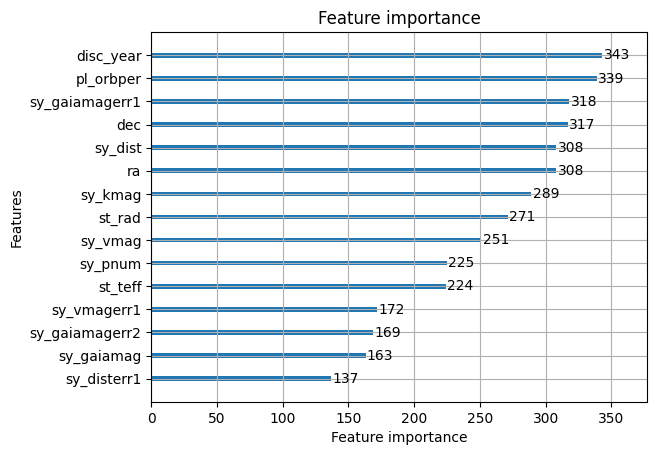

In [3]:
lgb.plot_importance(final_model, max_num_features=15)


In [4]:
# in nasa.ipynb (after training)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier   # or your model class
import joblib

# Example: if you have X_train, y_train already
pipeline = Pipeline([
    ("scaler", StandardScaler()),         # or use your fitted scaler object
    ("clf", RandomForestClassifier(n_estimators=100, random_state=42))
])

# If you already trained model separately and have a fitted scaler:
# pipeline = Pipeline([("scaler", fitted_scaler), ("clf", fitted_model)])

pipeline.fit(X_train, y_train)

# Save pipeline (recommended: single file)
joblib.dump(pipeline, "pipeline.pkl")


['pipeline.pkl']